<a href="https://colab.research.google.com/github/hamzafrd/Machine-Learning-Pemula/blob/main/TensorFlow_CNN_Rock_Paper_Scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Rock, Paper, Scissors

Importing lib and API
---


In [1]:
# Nama  : Hamza Firdaus
# Email : hamzaf625@gmail.com
import shutil 
import zipfile,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from google.colab import files
from PIL import ImageFile
print(tf.__version__)

2.8.2


GPU Checking
---
Source : https://colab.research.google.com/notebooks/gpu.ipynb

In [15]:
device = tf.test.gpu_device_name()
if device != '/device:GPU:0' :
  raise SystemError('GPU Device Not Found')
print('GPU at : {}'.format(device))

GPU at : /device:GPU:0


In [16]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.9058455429999412
GPU (s):
0.04148855600010393
GPU speedup over CPU: 70x


Getting dataset ready
---

In [ ]:
#dataset
!wget --no-check-certificate \
  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

In [ ]:
if(os.path.isdir('/tmp/image') == False):
  os.mkdir('/tmp/image')
!unzip '/tmp/rockpaperscissors.zip' -d '/tmp/image'

In [4]:
mac_dir = os.path.isdir('/tmp/image/__MACOSX')
train_base = os.path.isdir('/tmp/image/rockpaperscissors/rps-cv-images')
print(train_base)
print(mac_dir)

True
True


In [5]:
#jalan untuk pertama kali
if(mac_dir == True):
  shutil.copytree('/tmp/image/rockpaperscissors/rps-cv-images', '/tmp/image/val')
  shutil.rmtree('/tmp/image/__MACOSX')
if(train_base == True):
  shutil.copytree('/tmp/image/rockpaperscissors/rps-cv-images','/tmp/image/train')
  shutil.rmtree('/tmp/image/rockpaperscissors')

In [8]:
#train and val dir
base_dir = '/tmp/image'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

Train and val dataset
---

In [23]:
# menerapkan ImageDataGenerator untuk data latih dan data validasi.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4) # memotong/split data
    
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4)

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    seed=42,
    color_mode='rgb',
    class_mode='categorical',
    subset='training')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    seed=42,
    class_mode='categorical',
    subset='validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


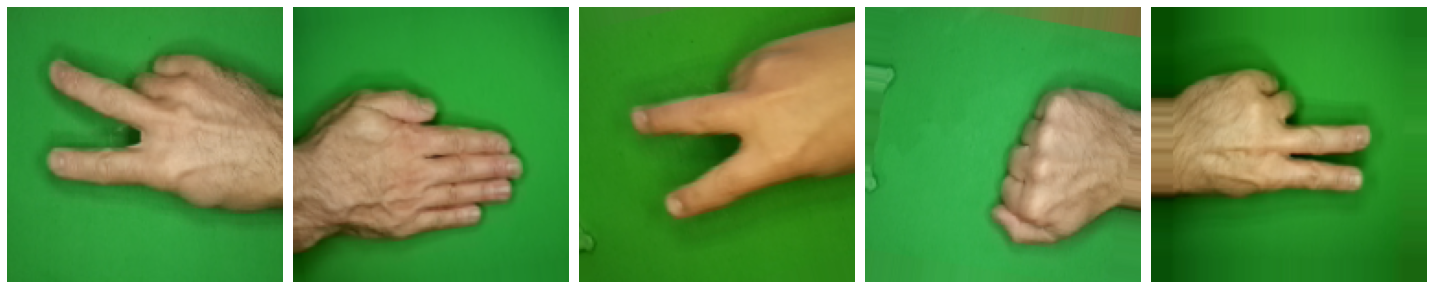

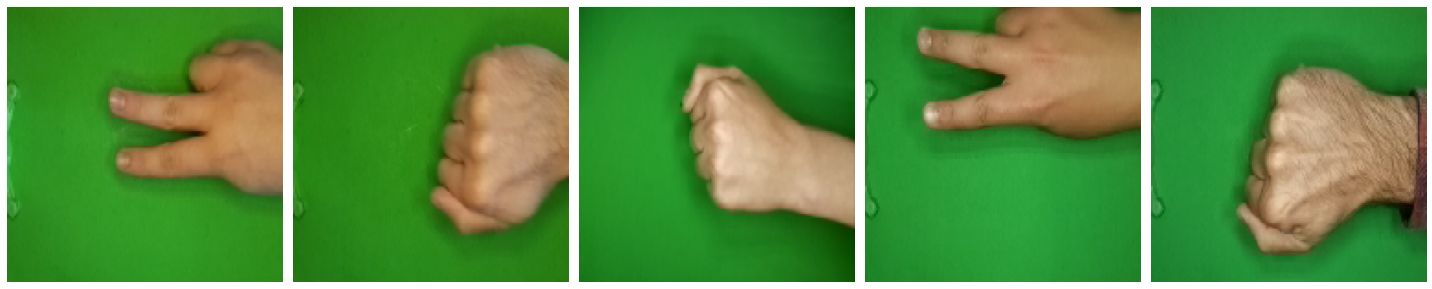

In [25]:
sample_train_images, _ = next(train_generator)
sample_val_images, _ = next(validation_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_train_images[:5])
plotImages(sample_val_images[:5])  

In [26]:
#Pembuatan Model Sequental (augmentation)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')       
])
# model.summary()

In [27]:
#Penambahan loss dan optimizer
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [28]:
# Penambahan fitur callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')> 0.96):
      print("\nAkurasi telah mencapai 96%, sangat tinggi ! \nNama : Hamza Firdaus\nEmail : Hamzaf625@gmail.com")
      self.model.stop_training = True

callbacks = myCallback()

In [29]:
#latih model dengan model.fit()
history = model.fit(train_generator, 
            steps_per_epoch=30, 
            epochs=20, #epoch terlalu banyak bisa menyebabkan overfitting. tapi bisa dinaikan jika blm sesuai keinginan.
            validation_data=validation_generator,
            validation_steps=27,
            verbose=2,
              callbacks=[callbacks])

Epoch 1/20
30/30 - 9s - loss: 1.1680 - accuracy: 0.4118 - val_loss: 1.1723 - val_accuracy: 0.3218 - 9s/epoch - 316ms/step
Epoch 2/20
30/30 - 9s - loss: 0.7826 - accuracy: 0.6396 - val_loss: 1.4701 - val_accuracy: 0.5046 - 9s/epoch - 292ms/step
Epoch 3/20
30/30 - 9s - loss: 0.5159 - accuracy: 0.8065 - val_loss: 0.2711 - val_accuracy: 0.9028 - 9s/epoch - 289ms/step
Epoch 4/20
30/30 - 9s - loss: 0.4127 - accuracy: 0.8441 - val_loss: 0.2398 - val_accuracy: 0.9167 - 9s/epoch - 288ms/step
Epoch 5/20
30/30 - 9s - loss: 0.3062 - accuracy: 0.8925 - val_loss: 0.2264 - val_accuracy: 0.9317 - 9s/epoch - 302ms/step
Epoch 6/20
30/30 - 9s - loss: 0.3098 - accuracy: 0.8871 - val_loss: 0.2234 - val_accuracy: 0.9329 - 9s/epoch - 290ms/step
Epoch 7/20
30/30 - 11s - loss: 0.2791 - accuracy: 0.9043 - val_loss: 0.1839 - val_accuracy: 0.9433 - 11s/epoch - 353ms/step
Epoch 8/20
30/30 - 9s - loss: 0.3308 - accuracy: 0.8925 - val_loss: 0.1466 - val_accuracy: 0.9537 - 9s/epoch - 287ms/step
Epoch 9/20
30/30 - 9s 

Visualization and Deployment
---

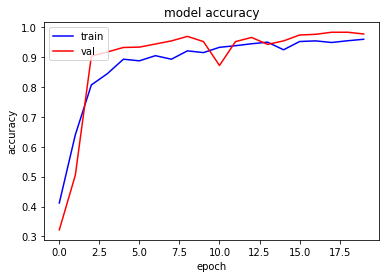

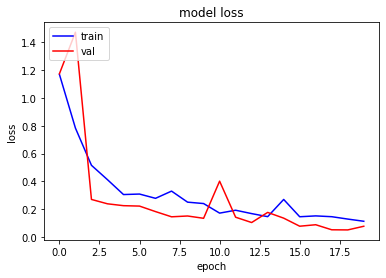

In [30]:
#menambah fitur visualisasi data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, color='blue')
plt.plot(val_acc, color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Saving 0657zSfiTYzP2jrl.png to 0657zSfiTYzP2jrl.png


Predict RESULT
0657zSfiTYzP2jrl.png
[[0. 0. 1.]]
scissors


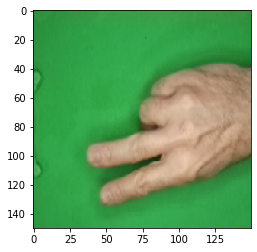

In [34]:
#import gambar
%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  #String output template
  paper     = "[[1. 0. 0.]]"
  rock      = "[[0. 1. 0.]]"
  scissors  = "[[0. 0. 1.]]"
  
  #convert numpy array into string
  result = np.array_str(classes) 
  
  print('\n')
  print('Predict RESULT')
  print(fn)
  print(result)

  #Changing result into human language
  if result == paper :
     print("paper")
  elif result == rock :
     print("rock")
  elif result == scissors :
     print("scissors")
  else :
     print("[[%PAPER. %ROCK. %SCISSORS]]")